In [1]:
import xarray as xr
import numpy as np
import cmocean as cm
import os
import pandas as pd
from matplotlib import cm as cmap
%matplotlib inline

In [2]:
from dask.distributed import Client

In [3]:
c=Client()
c

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40855 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40855/status,
Dashboard: /proxy/40855/status,Workers: 6
Total threads: 24,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40825,Workers: 6
Dashboard: /proxy/40855/status,Total threads: 24
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://127.0.0.1:39219,Total threads: 4
Dashboard: /proxy/39087/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:33173,


In [4]:
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import matplotlib.ticker as mticker
import cmocean as cm

In [5]:
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='#DFD1AF',
                                        linewidth=0.2)

In [6]:
import dask.dataframe as dd

In [7]:
import matplotlib
#matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["text.latex.preamble"] = r'\usepackage{xfrac}'

In [8]:
climatology_path = '/home/156/jm5970/hh5/climatology/'

In [9]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/satellite_KE_*.nc'
KE=xr.open_mfdataset(path,chunks={'latitude': 720//4, 'longitude': 1440//4, 'time': 10})

In [10]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/satellite_EKE_field_*.nc'
EKE=xr.open_mfdataset(path,chunks={'lat': 720//4, 'lon': 1440//4, 'time': 10})

In [11]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/eddy/satellite_TEKE_eddy*.nc'
TEKE=xr.open_mfdataset(path,chunks={'lat': 720//4, 'lon': 1440//4, 'time': 10})

In [12]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/residual/satellite_TEKE_res_*.nc'
TRKE=xr.open_mfdataset(path,chunks={'lat': 720//4, 'lon': 1440//4, 'time': 10})

In [13]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/diff/satellite_TEKE_res_*.nc'
TRKE_c=xr.open_mfdataset(path,chunks={'lat': 720//4, 'lon': 1440//4, 'time': 10})

In [14]:
# gridded_depth = xr.open_dataset('./bathymetry_025deg.nc')

In [18]:
eddy_climat = xr.open_mfdataset('/g/data/v45/jm5970/scripts_papers/paper_transient_climatology/netcdf_V2/eddy_stats_timeseries_*.nc')

In [19]:
lat_radians=np.radians(eddy_climat.lat)
lon_radians=np.radians(eddy_climat.lon)
earth_radius = 6371e3

grad_lon=lon_radians.copy()
grad_lon.data=np.gradient(lon_radians)

dx=grad_lon*earth_radius*np.cos(lat_radians)
dy=np.gradient(lat_radians)*earth_radius

area = (dx*dy).where(abs(dx.lat)>5)
area = area.where(eddy_climat.eddy_n>0)

In [20]:
eddy_n_nh = eddy_climat.eddy_n.sel(lat=slice(10,60)).sum(('lat','lon')).compute()
eddy_n_sh = eddy_climat.eddy_n.sel(lat=slice(-60,-10)).sum(('lat','lon')).compute()

In [21]:
abs_eddy_amp_dataset = eddy_climat.eddy_a_p.where(np.isfinite(eddy_climat.eddy_a_p),0)

In [22]:
abs_eddy_amp = 1/2 * (eddy_climat.eddy_a_p.where(np.isfinite(eddy_climat.eddy_a_p),0) - eddy_climat.eddy_a_n.where(np.isfinite(eddy_climat.eddy_a_n),0))

In [23]:
# abs_eddy_amp.isel(time=0).plot(vmin=-0.001,vmax=0.001)

In [24]:
abs_eddy_a_nh = ((abs_eddy_amp*100*area).sel(lat=slice(10,60)).sum(('lat','lon'))/area.sel(lat=slice(10,60)).sum(('lat','lon'))) .compute()
abs_eddy_a_sh = ((abs_eddy_amp*100*area).sel(lat=slice(-60,-10)).sum(('lat','lon'))/area.sel(lat=slice(-60,-10)).sum(('lat','lon'))).compute()

In [25]:
eddy_a_nh = ((abs(eddy_climat.eddy_a)*100*area).sel(lat=slice(10,60)).sum(('lat','lon'))/area.sel(lat=slice(10,60)).sum(('lat','lon'))).compute()
eddy_a_sh = ((abs(eddy_climat.eddy_a)*100*area).sel(lat=slice(-60,-10)).sum(('lat','lon'))/area.sel(lat=slice(-60,-10)).sum(('lat','lon'))).compute()

In [26]:
eddy_a_nh_pos = ((eddy_climat.eddy_a_p*100*area).sel(lat=slice(10,60)).sum(('lat','lon'))/area.sel(lat=slice(10,60)).sum()).compute()
eddy_a_sh_pos = ((eddy_climat.eddy_a_p*100*area).sel(lat=slice(-60,-10)).sum(('lat','lon'))/area.sel(lat=slice(-60,-10)).sum()).compute()

In [27]:
eddy_a_nh_neg = ((eddy_climat.eddy_a_n*100*area).sel(lat=slice(10,60)).sum(('lat','lon'))/area.sel(lat=slice(10,60)).sum()).compute()
eddy_a_sh_neg = ((eddy_climat.eddy_a_n*100*area).sel(lat=slice(-60,-10)).sum(('lat','lon'))/area.sel(lat=slice(-60,-10)).sum()).compute()

In [28]:
cbar_text=['Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Jan']

In [29]:
from matplotlib.collections import LineCollection
import matplotlib as mpl

In [30]:
year=[int(t) for t in eddy_a_nh['time'].dt.strftime('%Y').values]

In [31]:
path='/g/data/rr7/JRA55/6hr/atmos/'

In [32]:
u_10_p='uas/v1/uas_*.nc'
v_10_p='vas/v1/vas_*.nc'

In [33]:
u_10=xr.open_mfdataset(path+u_10_p,combine='nested',concat_dim='time',chunks={'time':100,'lon':320,'lat':160},parallel=True)
v_10=xr.open_mfdataset(path+v_10_p,combine='nested',concat_dim='time',chunks={'time':100,'lon':320,'lat':160},parallel=True)

In [34]:
wind_mag = np.sqrt(u_10.uas**2 + v_10.vas**2)

In [35]:
wind_mag = wind_mag.chunk({'time':100})

In [36]:
mean_wind_mag_year_nh = wind_mag.sel(lat=slice(10,60)).mean(('lat','lon')).rolling(time=30, center=True).mean().groupby('time.dayofyear').mean('time').compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))


In [37]:
mean_wind_mag_year_sh = wind_mag.sel(lat=slice(-60,-10)).mean(('lat','lon')).rolling(time=30, center=True).mean().groupby('time.dayofyear').mean('time').compute()

In [38]:
from matplotlib import colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Truncate colormap.
    """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [39]:
ice_colormap = plt.get_cmap(truncate_colormap(cm.cm.balance,0.05,0.95), 12)

In [40]:
import matplotlib.ticker as mtick

In [41]:
mean_wind_mag_year_nh_month = wind_mag.sel(lat=slice(10,60)).mean(('lat','lon')).groupby('time.month').mean('time').compute()
mean_wind_mag_year_sh_month = wind_mag.sel(lat=slice(-60,-10)).mean(('lat','lon')).groupby('time.month').mean('time').compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: overflow encountered in square
  return func(*(_execute_task(a, cache) for a in args))


In [43]:
c_eddy_climat = xr.open_mfdataset('/g/data/v45/jm5970/scripts_papers/paper_transient_climatology/netcdf/chelton_eddy_stats_timeseries_*.nc')

In [46]:
c_eddy_n_nh = c_eddy_climat.eddy_n.sel(lat=slice(10,60)).sum(('lon','lat')).compute()
c_eddy_n_sh = c_eddy_climat.eddy_n.sel(lat=slice(-60,-10)).sum(('lon','lat')).compute()

In [47]:
c_eddy_a_nh = c_eddy_climat.eddy_a.sel(lat=slice(10,60)).mean(('lon','lat')).compute()
c_eddy_a_sh = c_eddy_climat.eddy_a.sel(lat=slice(-60,-10)).mean(('lon','lat')).compute()

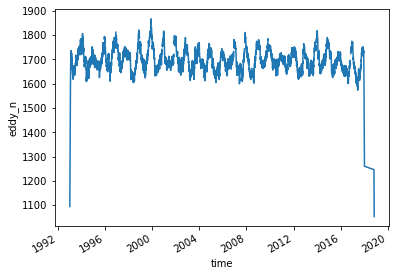

In [48]:
c_eddy_n_sh.where(c_eddy_n_sh<2000).plot()

In [49]:
c_eddy_n_nh = c_eddy_n_nh.where(c_eddy_n_nh<1200).sel(time=slice('1994','2016'))
c_eddy_n_sh = c_eddy_n_sh.where(c_eddy_n_sh<2000).sel(time=slice('1994','2016'))
c_eddy_a_nh = c_eddy_a_nh.where(c_eddy_n_nh<1200).sel(time=slice('1994','2016'))
c_eddy_a_sh = c_eddy_a_sh.where(c_eddy_n_sh<2000).sel(time=slice('1994','2016'))

In [50]:
matplotlib.rcParams.update({'font.size': 9})
fsize=9

In [51]:
import matplotlib.gridspec as gridspec

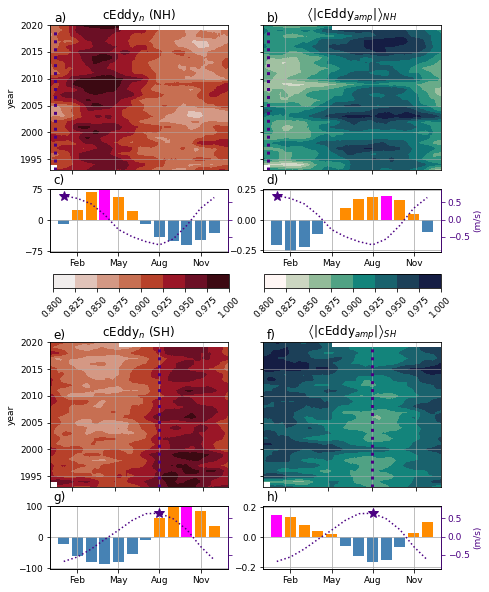

In [59]:
wind_color = 'indigo'
fig=plt.figure(figsize=(7,10))

#################################################################
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.4)
#################################################################

grid_top_left = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid[0,0], hspace=0.3)
grid_top_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid[0,1], hspace=0.3)
grid_bottom_left = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid[1,0], hspace=0.3)
grid_bottom_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid[1,1], hspace=0.3)

axs1 = fig.add_subplot(grid_top_left[0:2])

data_frame = (eddy_n_nh.rolling(time=30, center=True).mean()*10000).to_dataframe()
data_frame['year']=data_frame.index.year
data_frame['day']=data_frame.index.dayofyear
array = data_frame.set_index(['year','day']).to_xarray()
normalized_array = array/array.max()
n_cbar = normalized_array.eddy_n.plot.contourf(
    ax=axs1,
    cmap=cm.cm.amp,
    add_colorbar=False,
    vmin=0.8,
    vmax=1,
    levels=9
)
wind_mag_plot = mean_wind_mag_year_nh
max_day = wind_mag_plot.argmax()
axs1.plot([max_day,max_day],[1993,2019],':',color=wind_color,linewidth=3)
axs1.set_ylim(1993,2020)
axs1.set_xticks(np.arange(45,365,2*45))
axs1.grid(linewidth=0.5)
axs1.set_xticklabels([])
axs1.set_xlabel('')

axs1.set_title('$\mathrm{cEddy}_{n}$ (NH)',y=1,fontsize=12)
# axs1.set_xticklabels(cbar_text[::-2], minor=False, rotation=45);
################################################################
axs2 = fig.add_subplot(grid_top_right[0:2])
plt.setp(axs2.get_yticklabels(), visible=False)

data_frame = (abs_eddy_a_nh.rolling(time=30, center=True).mean()*10000).to_dataframe(name='eddy_a')
data_frame['year']=data_frame.index.year
data_frame['day']=data_frame.index.dayofyear
array = data_frame.set_index(['year','day']).to_xarray()
normalized_array = array/array.max()
normalized_array.eddy_a.plot.contourf(
    ax=axs2,
    cmap=cm.cm.tempo,
    add_colorbar=False,
    vmin=0.8,
    vmax=1,
    levels=9
)

wind_mag_plot = mean_wind_mag_year_nh
max_day = wind_mag_plot.argmax()
axs2.plot([max_day,max_day],[1993,2019],':',color=wind_color,linewidth=3)
axs2.set_ylim(1993,2020)
axs2.set_xticks(np.arange(45,365,2*45))
axs2.grid(linewidth=0.5)
axs2.set_xticklabels([])
axs2.set_xlabel('')
axs2.set_ylabel('')

axs2.set_title(r'$\left<|\mathrm{cEddy}_{amp}|\right>_{NH}$',y=1,fontsize=12)
# axs2.set_xticklabels(cbar_text[::-2], minor=False, rotation=45);
# #################################################################
axs3 = fig.add_subplot(grid_bottom_left[0:2])

data_frame = (eddy_n_sh.rolling(time=30, center=True).mean()*10000).to_dataframe()
data_frame['year']=data_frame.index.year
data_frame['day']=data_frame.index.dayofyear
array = data_frame.set_index(['year','day']).to_xarray()
normalized_array = array/array.max()
normalized_array.eddy_n.plot.contourf(
    ax=axs3,
    cmap=cm.cm.amp,
    add_colorbar=False,
    vmin=0.8,
    vmax=1,
    levels=9
)

wind_mag_plot = mean_wind_mag_year_sh
max_day = wind_mag_plot.argmax()
axs3.plot([max_day,max_day],[1993,2019],':',color=wind_color,linewidth=3)
axs3.set_ylim(1993,2020)
axs3.set_xticks(np.arange(45,365,2*45))
axs3.grid(linewidth=0.5)
axs3.set_xticklabels([])
axs3.set_xlabel('')

axs3.set_title('$\mathrm{cEddy}_{n}$ (SH)',y=1,fontsize=12)
# axs3.set_xticklabels(cbar_text[::-2], minor=False, rotation=45);
# #################################################################
axs4 = fig.add_subplot(grid_bottom_right[0:2])
plt.setp(axs4.get_yticklabels(), visible=False)
                       
data_frame = (abs_eddy_a_sh.rolling(time=30, center=True).mean()*10000).to_dataframe(name='eddy_a')
data_frame['year']=data_frame.index.year
data_frame['day']=data_frame.index.dayofyear
array = data_frame.set_index(['year','day']).to_xarray()
normalized_array = array/array.max()
amp_cbar = normalized_array.eddy_a.plot.contourf(
    ax=axs4,
    cmap=cm.cm.tempo,
    add_colorbar=False,
    vmin=0.8,
    vmax=1,
    levels=9
)
wind_mag_plot = mean_wind_mag_year_sh
max_day = wind_mag_plot.argmax()
axs4.plot([max_day,max_day],[1993,2019],':',color=wind_color,linewidth=3)
axs4.set_ylim(1993,2020)
axs4.set_xticks(np.arange(45,365,2*45))
axs4.grid(linewidth=0.5)
axs4.set_xticklabels([])
axs4.set_xlabel('')
axs4.set_ylabel('')

axs4.set_title(r'$\left<|\mathrm{cEddy}_{amp}|\right>_{SH}$',y=1,fontsize=12)
# axs4.set_xticklabels(cbar_text[::-2], minor=False, rotation=45);
# #################################################################

cbar_ax = fig.add_axes([0.13, 0.515, 0.35, 0.02],label='cbar')
cbar = fig.colorbar(n_cbar, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(rotation=45)

cbar_ax = fig.add_axes([0.55, 0.515, 0.35, 0.02],label='cbar')
cbar = fig.colorbar(amp_cbar, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(rotation=45)

# ########################################################################
# ############################### Seasonal ###############################
# ########################################################################
axs5 = fig.add_subplot(grid_top_left[2])
eddy_n_climatology = eddy_n_nh.groupby('time.month').mean('time')

anomaly_plot = eddy_n_climatology-eddy_n_climatology.mean()
axs5.bar(eddy_n_climatology.month, (anomaly_plot).where(anomaly_plot>0),color='darkorange')
axs5.bar(eddy_n_climatology.month, (anomaly_plot).where(anomaly_plot<0),color='steelblue')
axs5.bar(eddy_n_climatology.month, (anomaly_plot).where(anomaly_plot==anomaly_plot.max()),color='magenta')

# c_eddy_n_climatology = c_eddy_n_nh.groupby('time.month').mean('time')
# anomaly_plot = c_eddy_n_climatology - c_eddy_n_climatology.mean()
# axs5.bar(c_eddy_n_climatology.month, (anomaly_plot),color='none',edgecolor='black', hatch="/")
axs5.set_ylim(-76,76)
axs5.set_yticks((-75,0,75))

axs5_t = axs5.twinx()
wind_mag_plot = mean_wind_mag_year_nh_month-mean_wind_mag_year_nh_month.mean()
axs5_t.plot(wind_mag_plot.month, wind_mag_plot.values, linestyle=':',  color=wind_color)
max_value = wind_mag_plot.where(wind_mag_plot==wind_mag_plot.max())
axs5_t.plot(max_value.month, max_value.values, marker='*', color=wind_color, zorder=10, markersize=10)
axs5_t.set_ylim(wind_mag_plot.min()-0.2,wind_mag_plot.max()+0.2)

axs5_t.set_ylabel('')
axs5_t.set_xlabel('')
axs5_t.set_yticklabels([])
axs5_t.spines['right'].set_color(wind_color)
axs5_t.tick_params(axis='y', colors=wind_color)
# axs5_t.set_yticks([])
axs5.grid()
axs5.set_xticks(np.arange(2,13,3))
axs5.set_xticklabels(['Feb','May','Aug','Nov'],fontsize=fsize);

# ###############################################################
axs6 = fig.add_subplot(grid_top_right[2])
eddy_a_climatology = abs_eddy_a_nh.groupby('time.month').mean('time')

anomaly_plot = eddy_a_climatology-eddy_a_climatology.mean()
axs6.bar(eddy_a_climatology.month, (anomaly_plot).where(anomaly_plot>0),color='darkorange')
axs6.bar(eddy_a_climatology.month, (anomaly_plot).where(anomaly_plot<0),color='steelblue')
axs6.bar(eddy_a_climatology.month, (anomaly_plot).where(anomaly_plot==anomaly_plot.max()),color='magenta')

# c_eddy_a_climatology = c_eddy_a_nh.groupby('time.month').mean('time')
# anomaly_plot = c_eddy_a_climatology-c_eddy_a_climatology.mean()
# axs6.bar(c_eddy_a_climatology.month, (anomaly_plot),color='none',edgecolor='black', hatch="/")
axs6.set_ylim(-0.26,0.26)
axs6.set_yticks((-0.25,0,0.25))

axs6_t = axs6.twinx()
wind_mag_plot = mean_wind_mag_year_nh_month-mean_wind_mag_year_nh_month.mean()
axs6_t.plot(wind_mag_plot.month, wind_mag_plot.values, linestyle=':',  color=wind_color)
max_value = wind_mag_plot.where(wind_mag_plot==wind_mag_plot.max())
axs6_t.plot(max_value.month, max_value.values, marker='*', color=wind_color, zorder=10, markersize=10)
axs6_t.set_ylim(wind_mag_plot.min()-0.2,wind_mag_plot.max()+0.2)

axs6_t.set_ylabel('')
axs6_t.set_xlabel('')
# axs6_t.set_yticklabels([])
# axs6_t.set_yticks([])
axs6_t.spines['right'].set_color(wind_color)
axs6_t.tick_params(axis='y', colors=wind_color)
axs6_t.set_ylabel('(m/s)',color=wind_color)
axs6.grid()
axs6.set_xticks(np.arange(2,13,3))
axs6.set_xticklabels(['Feb','May','Aug','Nov'],fontsize=fsize);

# ###############################################################
axs7 = fig.add_subplot(grid_bottom_left[2])
eddy_n_climatology = eddy_n_sh.groupby('time.month').mean('time')

anomaly_plot = eddy_n_climatology-eddy_n_climatology.mean()
axs7.bar(eddy_n_climatology.month, (anomaly_plot).where(anomaly_plot>0),color='darkorange')
axs7.bar(eddy_n_climatology.month, (anomaly_plot).where(anomaly_plot<0),color='steelblue')
axs7.bar(eddy_n_climatology.month, (anomaly_plot).where(anomaly_plot==anomaly_plot.max()),color='magenta')

# c_eddy_n_climatology = c_eddy_n_sh.groupby('time.month').mean('time')
# anomaly_plot = c_eddy_n_climatology - c_eddy_n_climatology.mean()
# axs7.bar(c_eddy_n_climatology.month, (anomaly_plot),color='none',edgecolor='black', hatch="/")
axs7.set_ylim(-101,101)

axs7_t = axs7.twinx()
wind_mag_plot = mean_wind_mag_year_sh_month-mean_wind_mag_year_sh_month.mean()
axs7_t.plot(wind_mag_plot.month, wind_mag_plot.values, linestyle=':',  color=wind_color)
max_value = wind_mag_plot.where(wind_mag_plot==wind_mag_plot.max())
axs7_t.plot(max_value.month, max_value.values, marker='*', color=wind_color, zorder=10, markersize=10)
axs7_t.set_ylim(wind_mag_plot.min()-0.2,wind_mag_plot.max()+0.2)

axs7_t.set_ylabel('')
axs7_t.set_xlabel('')
axs7_t.set_yticklabels([])
axs7_t.spines['right'].set_color(wind_color)
axs7_t.tick_params(axis='y', colors=wind_color)
# axs7_t.set_yticks([])
axs7.grid()
axs7.set_xticks(np.arange(2,13,3))
axs7.set_xticklabels(['Feb','May','Aug','Nov'],fontsize=fsize);

###############################################################
axs8 = fig.add_subplot(grid_bottom_right[2])
eddy_a_climatology = abs_eddy_a_sh.groupby('time.month').mean('time')

anomaly_plot = eddy_a_climatology-eddy_a_climatology.mean()
axs8.bar(eddy_a_climatology.month, (anomaly_plot).where(anomaly_plot>0),color='darkorange')
axs8.bar(eddy_a_climatology.month, (anomaly_plot).where(anomaly_plot<0),color='steelblue')
axs8.bar(eddy_a_climatology.month, (anomaly_plot).where(anomaly_plot==anomaly_plot.max()),color='magenta')

# c_eddy_a_climatology = c_eddy_a_sh.groupby('time.month').mean('time')
# anomaly_plot = c_eddy_a_climatology-c_eddy_a_climatology.mean()
# axs8.bar(c_eddy_a_climatology.month, (anomaly_plot),color='none',edgecolor='black', hatch="/")
axs8.set_ylim(-0.21,0.21)
axs8.set_yticks((-0.2,0,0.2))

axs8_t = axs8.twinx()
wind_mag_plot = mean_wind_mag_year_sh_month-mean_wind_mag_year_sh_month.mean()
axs8_t.plot(wind_mag_plot.month, wind_mag_plot.values, linestyle=':',  color=wind_color)
max_value = wind_mag_plot.where(wind_mag_plot==wind_mag_plot.max())
axs8_t.plot(max_value.month, max_value.values, marker='*', color=wind_color, zorder=10, markersize=10)
axs8_t.set_ylim(wind_mag_plot.min()-0.2,wind_mag_plot.max()+0.2)

axs8_t.set_ylabel('')
axs8_t.set_xlabel('')
# axs8_t.set_yticklabels([])
# axs8_t.set_yticks([])
axs8_t.spines['right'].set_color(wind_color)
axs8_t.tick_params(axis='y', colors=wind_color)
axs8_t.set_ylabel('(m/s)',color=wind_color)
axs8.grid()
axs8.set_xticks(np.arange(2,13,3))
axs8.set_xticklabels(['Feb','May','Aug','Nov'],fontsize=fsize);
###############################################################

axs1.text(0.02,1.02,r'a)',fontsize=12,transform=axs1.transAxes)
axs2.text(0.02,1.02,r'b)',fontsize=12,transform=axs2.transAxes)
axs3.text(0.02,1.02,r'e)',fontsize=12,transform=axs3.transAxes)
axs4.text(0.02,1.02,r'f)',fontsize=12,transform=axs4.transAxes)
axs5.text(0.02,1.08,r'c)',fontsize=12,transform=axs5.transAxes)
axs6.text(0.02,1.08,r'd)',fontsize=12,transform=axs6.transAxes)
axs7.text(0.02,1.08,r'g)',fontsize=12,transform=axs7.transAxes)
axs8.text(0.02,1.08,r'h)',fontsize=12,transform=axs8.transAxes)

###############################################################
plt.savefig('Figure_7_eddy_stats_time_plot.pdf',dpi=300,bbox_inches='tight')